In [1]:
import re
import json

In [2]:
from templates import extract_template

In [3]:
with open("grade_7x_subtitle.json", 'r') as f:
    subtitles = json.load(f)

In [4]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_openai import ChatOpenAI
from typing import Annotated

In [5]:
from templates import *
from langchain_experimental.tools import PythonREPLTool
from langchain.tools import BaseTool, StructuredTool, tool

In [17]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                " {system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    # prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [7]:
@tool
def clean_up_response(
    answer: Annotated[str, "The problems and explanation pair for you to split them into separate pairs"],
):
    """Use this tool to extract problems-explanation pair from llm's response and store them in a list for clarity"""
    problem_explanation = []
    pattern = r"###\s*原题\s*：?([\s\S]*?)###\s*讲解\s*：?([\s\S]*?)(?=###|$)"
    matches = re.findall(pattern, answer)

    for i, match in enumerate(matches, 1):
        original, explanation = match
        problem_explanation.append([original, explanation])
    return problem_explanation

In [8]:
import operator
from langchain_core.messages import AIMessage

from langchain_openai import ChatOpenAI
from typing import Annotated, Sequence, TypedDict


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [9]:
def agent_node(state, agent, name):
    result = agent.invoke(state)

    if isinstance(result, ToolMessage):
        pass
    else:
        result =  AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        'messages': [result],
        'sender': name,
    }

In [21]:
import functools
llm = ChatOpenAI(model="gpt-4o")

extract_template = extract_template.format(subtitle=subtitles[22])
extractor_agent = create_agent(llm, [clean_up_response], system_message=extract_template)
extractor_node = functools.partial(agent_node, agent=extractor_agent, name="Extractor")

validator_agent = create_agent(llm, [clean_up_response], system_message="请逐一检查Extractor提取出的题目是否完整，判断根据现有条件是否可能有解，输出所有有解的题目和解答，保留格式")
validator_node = functools.partial(agent_node, agent=validator_agent, name="Validator")

In [19]:
from langgraph.prebuilt import ToolNode

tools = [clean_up_response]
tool_node = ToolNode(tools)

In [20]:
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINISH" in last_message.content:
        return "__end__"
    return "continue"

In [23]:
workflow = StateGraph(AgentState)

workflow.add_node("Extractor", extractor_node)
workflow.add_node("Validator", validator_node)
# workflow.add_node("call_tool", tool_node)

workflow.add_edge("Extractor", "Validator")
workflow.add_edge("Validator", END)
workflow.add_edge(START, "Extractor")

graph = workflow.compile()

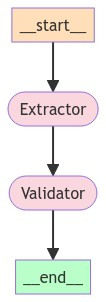

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="请提取"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Extractor': {'messages': [AIMessage(content='### 原题：\n引力学校篮球联赛中每场比赛都要分出胜负每队胜一场得二分一场得一分某队在十场比赛中得到16分那么这个对胜负场应分别是多少呢。\n\n### 讲解：\n依据引力的问题你能列一元一次方程吗？因为这个队伍参加十场比赛，所以设胜X场，则十减X场。又由于共得16分，所以2X加十减X等于16。那你能不能根据题目直接设两个未知数使列方程变得容易呢？设这个队胜X场，负Y场。根据题意可以得：\n\n\\[ X + Y = 10 \\]\n\\[ 2X + Y = 16 \\]\n\n请大家观察这两个方程与一元一次方程有什么不同呢？它们有什么特点呢？每个方程都含有两个未知数，并含有未知数的项的次数都是一。像这样的方程称之为二元一次方程。类比一元一次方程的概念，我们得到二元一次方程的概念：含有两个未知数，并且含有未知数的项的次数都是一的方程叫做二元一次方程。特别注意含有未知数的项的次数都是一，即方程两边都是整式。\n\n同学们，利用二元一次方程的概念请大家完成例一。\n\n由于方程是关于XY的二元一次方程，所以XY是未知数。所以含有X或Y的项的次数应为一。因此M加二应该等于一，所以M等于一。N减一应该等于一，所以N应该等于二。\n\n同学们，利用二元一次方程的概念请大家完成下面一个巩固练习。\n\n因为同样是关于XY的二元一次方程，所以第一项MXY的次数为二，所以此项应该没有，所以M等于零。含Y的项的次数应该是一，所以N加五等于一，所以N等于四。', response_metadata={'token_usage': {'completion_tokens': 450, 'prompt_tokens': 2014, 'total_tokens': 2464}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_18cc0f1fa0', 'finish_reason': 'stop', 'logprobs': None}, name='Extractor', id='run-01354e5b-e9f7-4f46-a420-adcff76218c0-0', usage_metadata={'input_token